# Calculating change over time


## imports


In [1]:
import leafmap
import leafmap.colormaps as cm
import requests
import rasterio as rio
from rasterio.merge import merge
import glob
from rasterio.plot import reshape_as_image
import geopandas as gpd

## searching for data


In [2]:
url = "https://earth-search.aws.element84.com/v1/"
collection = "sentinel-2-l2a"
time_range = "2023-08-01/2023-08-31"

In [3]:
# bbox for dallas metro
bbox = [
    -97.06213756027009,
    32.97324551867027,
    -96.46807822577594,
    33.3578329610085,
]

In [4]:
search_gdf = leafmap.stac_search(
    url=url,
    max_items=10,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
    sortby=[{"field": "properties.eo:cloud_cover", "direction": "asc"}],
    get_gdf=True,
)

In [5]:
search_gdf.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

## exploring and filtering search results


<Axes: >

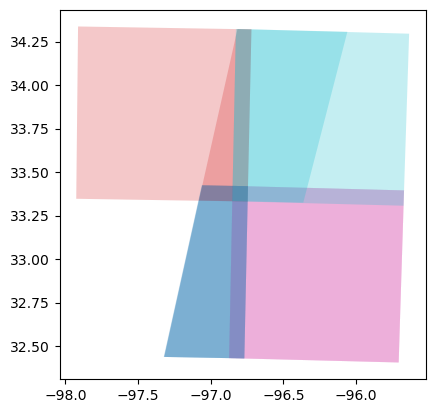

In [6]:
search_gdf.plot("mgrs:grid_square", alpha=0.25)

In [7]:
search_gdf["s2:granule_id"].value_counts()

s2:granule_id
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SQB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SPC_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SPB_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A042537_T14SQB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SPC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A042580_T14SQC_N05.09    1
S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A042394_T14SPB_N05.09    1
S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A033700_T14SQC_N05.09    1
Name: count, dtype: int64

In [8]:
search_gdf["area"] = search_gdf.geometry.area

In [9]:
search_gdf.sort_values("area", ascending=False, inplace=True)

In [10]:
search_gdf

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,area
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z,1.174444
9,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z,1.172798
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z,1.161135
1,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-05T04:59:04.872Z,sentinel-2a,sentinel-2,[msi],0.005262,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:46.231000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/73a7...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:59:04.872Z,1.161135
5,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-15T04:10:46.325Z,sentinel-2a,sentinel-2,[msi],0.014575,32614,14,S,QB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:46.612000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/cac3...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:10:46.325Z,1.161135
7,"POLYGON ((-96.82664 34.32236, -96.85153 33.333...",2023-08-18T06:09:55.100Z,sentinel-2a,sentinel-2,[msi],0.040440,32614,14,S,QC,...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:28.416000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/c613...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:09:55.100Z,0.620451
4,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z,0.432199
8,"POLYGON ((-97.05919 33.42438, -97.32056 32.437...",2023-08-05T04:52:48.750Z,sentinel-2a,sentinel-2,[msi],0.059570,32614,14,S,PB,...,S2A_OPER_MSI_L2A_TL_2APS_20230804T235402_A0423...,0.970632,2023-08-04T17:14:49.014000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a5ff...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-05T04:52:48.750Z,0.429551
3,"POLYGON ((-97.05790 33.42436, -97.31949 32.437...",2023-08-20T04:36:25.463Z,sentinel-2b,sentinel-2,[msi],0.009056,32614,14,S,PB,...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:49.046000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ee80...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:36:25.463Z,0.428386
6,"POLYGON ((-96.81576 34.32217, -97.08134 33.336...",2023-08-20T04:30:59.255Z,sentinel-2b,sentinel-2,[msi],0.017386,32614,14,S,PC,...,S2B_OPER_MSI

In [11]:
search_gdf.drop_duplicates("mgrs:grid_square", inplace=True)

<Axes: >

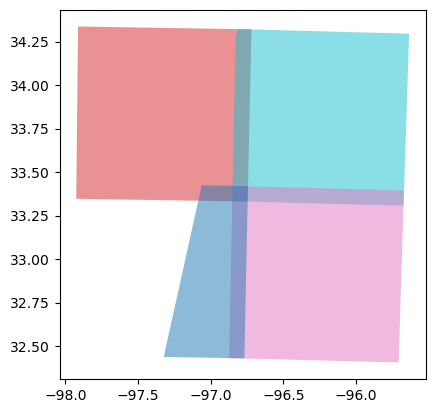

In [12]:
search_gdf.iloc[0:4].plot("s2:granule_id", alpha=0.5)

In [13]:
# # create a query searching for unique datastrip ids based on the above
q = {"s2:granule_id": {"in": search_gdf["s2:granule_id"].iloc[0:4].unique().tolist()}}

search_gdf2 = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_gdf=True,
)

In [14]:
search_gdf2

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-96.84938 33.42092, -96.87321 32.431...",2023-08-20T04:40:37.325Z,sentinel-2b,sentinel-2,[msi],0.004539,32614,14,S,QB,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:46.266000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/a707...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:40:37.325Z
1,"POLYGON ((-96.81576 34.32217, -96.82780 34.277...",2023-08-20T04:44:38.807Z,sentinel-2b,sentinel-2,[msi],0.076934,32614,14,S,QC,...,S2B_OPER_MSI_L2A_DS_2BPS_20230819T223356_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20230819T223356_A0337...,0.975198,2023-08-19T17:14:31.780000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/Q...,roda-sentinel2/workflow-sentinel2-to-stac/2524...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-20T04:44:38.807Z
2,"POLYGON ((-97.91284 34.33683, -97.92531 33.346...",2023-08-18T06:10:25.042Z,sentinel-2a,sentinel-2,[msi],0.006437,32614,14,S,PC,...,S2A_OPER_MSI_L2A_DS_2APS_20230818T002256_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230818T002256_A0425...,0.974489,2023-08-17T17:24:31.907000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/a898...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-18T06:10:25.042Z
3,"POLYGON ((-97.06177 33.42442, -97.32332 32.437...",2023-08-15T04:07:22.379Z,sentinel-2a,sentinel-2,[msi],0.014211,32614,14,S,PB,...,S2A_OPER_MSI_L2A_DS_2APS_20230815T002553_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20230815T002553_A0425...,0.973476,2023-08-14T17:14:49.390000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/14/S/P...,roda-sentinel2/workflow-sentinel2-to-stac/ccee...,True,{'sentinel2-to-stac': '0.1.1'},2023-08-15T04:07:22.379Z


<Axes: >

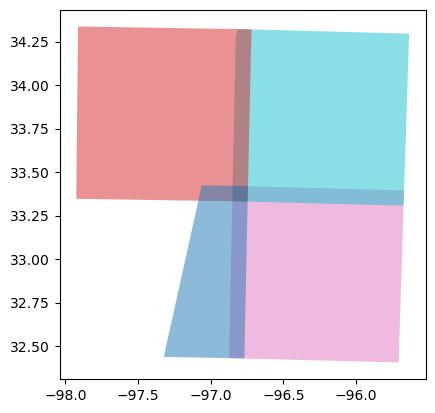

In [15]:
search_gdf2.plot("mgrs:grid_square", alpha=0.5)

### plot to accentuate paved and non-paved divide


In [16]:
search_gdf2_list = leafmap.stac_search(
    url=url,
    max_items=4,
    collections=[collection],
    bbox=bbox,
    datetime=time_range,
    query=q,
    get_links=True,
)

In [17]:
m = leafmap.Map()

for layer in search_gdf2_list:
    m.add_stac_layer(layer, bands=["nir", "red", "green"], name=layer.split("/")[-1])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### download files for analysis


In [ ]:
def get_raster_band_urls(item: str, bands: list | None = None):
    available_bands = leafmap.stac_bands(item)
    stac = requests.get(item).json()
    band_urls = {
        x: stac["assets"][x]["href"]
        for x in available_bands
        if stac["assets"][x]["href"].startswith("http")
    }

    # if bands, only return bands in list
    if bands:
        band_urls = {x: band_urls[x] for x in bands if x in band_urls}

    return band_urls


def download_stac_layers(layers, out_dir, bands=None):
    for layer in layers:
        band_urls = get_raster_band_urls(layer, bands)
        for band, url in band_urls.items():
            print(url)
            out_file = f"{out_dir}/{layer.split('/')[-1]}_{band}.tif"
            leafmap.download_file(url, out_file, overwrite=False)


def get_stac_crs(item):
    stac = requests.get(item).json()
    return stac["properties"]["proj:epsg"]

In [ ]:
stac_crs = get_stac_crs(search_gdf2_list[0])

In [ ]:
download_stac_layers(
    search_gdf2_list,
    "../Data/stac/dallas",
)

In [ ]:
# mosaic files based on band name


def mosaic_by_band(
    dir,
    bands: list = [
        "red",
        "blue",
        "green",
        "nir",
        "coastal",
        "nir08",
        "nir09",
        "rededge1",
        "rededge2",
        "rededge3",
        "scl",
        "swir16",
        "swir22",
    ],
    crs: str = None,
):
    mosaics = {}
    for band in bands:
        files = glob.glob(f"{dir}/*{band}.tif")

        out_file = f"{dir}/mosaic_{band}_.tif"
        raster_data = [rio.open(f) for f in files]

        mosaic, out_trans = merge(raster_data)
        out_meta = raster_data[0].meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_trans,
                "crs": f"epsg:{crs}",
            }
        )

        with rio.open(out_file, "w", **out_meta) as dest:
            dest.write(mosaic)

        mosaics[band] = out_file

    return mosaics

In [ ]:
mosaic_bands_all = mosaic_by_band("../Data/stac/dallas", crs=stac_crs)

In [ ]:
mosaic_bands_all

In [ ]:
nir = rio.open(mosaic_bands_all["nir"]).read(1).astype("float32")
red = rio.open(mosaic_bands_all["red"]).read(1).astype("float32")

### calculate NDVI


In [ ]:
ndvi = (nir - red) / (nir + red)

In [ ]:
import numpy as np

In [ ]:
# fill nan with -2, outside of the range but not so far outside
ndvi[np.isnan(ndvi)] = -1.1

In [ ]:
ndvi

In [ ]:
ndvi_mult = ndvi * 10  # to be able to visualize more easily

In [ ]:
ndvi_mult

In [ ]:
ndvi_image = leafmap.array_to_image(ndvi, source=mosaic_bands_all["nir"])

In [ ]:
ndvi_multi_image = leafmap.array_to_image(ndvi_mult, source=mosaic_bands_all["nir"])

In [ ]:
m = leafmap.Map()
m.add_raster(ndvi_multi_image, layer_name="NDVI", vmin=-10, vmax=10, cmap="PiYG")
m

In [ ]:
# get histogram of ndvi image values

import matplotlib.pyplot as plt

plt.hist(ndvi[ndvi != -1.1].ravel(), bins=100, color="red", alpha=0.7)

In [ ]:
def categorize_np_array(array):

    cat_array = np.zeros(array.shape)
    cat_array[array < 1] = 5
    cat_array[array < 0.8] = 4
    cat_array[array < 0.6] = 3
    cat_array[array < 0.4] = 2
    cat_array[array < 0.2] = 1

    return cat_array

In [ ]:
cat_ndvi = categorize_np_array(ndvi)

In [ ]:
cat_ndvi

In [ ]:
ndvi_image_cat = leafmap.array_to_image(cat_ndvi, source=mosaic_bands_all["nir"])

In [ ]:
m = leafmap.Map()
m.add_raster(
    ndvi_image_cat, layer_name="NDVI", vmin=1, vmax=5, cmap="Set1", draw_control=False
)
m.add_colormap(
    "Set1",
    label="ndvi",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=1,
    vmax=5,
)

m

## k-means


In [ ]:
def resample_raster(in_file, out_file, upscale_factor=0.5):
    with rio.open(in_file) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor),
            ),
            resampling=rio.enums.Resampling.bilinear,
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]), (dataset.height / data.shape[-2])
        )

        # update metadata
        meta = dataset.meta.copy()
        meta.update(
            {
                "height": data.shape[1],
                "width": data.shape[2],
                "transform": transform,
            }
        )

        with rio.open(out_file, "w", **meta) as dst:
            dst.write(data)

In [ ]:
for band in mosaic_bands_all.keys():
    print(band, rio.open(mosaic_bands_all[band]).read(1).shape)

In [ ]:
# set resampling ratio for each band- note that some are higher resolution than others and need a different scaling factor
bands_to_resample = {
    "red": 0.25,
    "blue": 0.25,
    "green": 0.25,
    "nir": 0.25,
    "nir08": 0.5,
    "rededge1": 0.5,
    "rededge2": 0.5,
    "rededge3": 0.5,
    "scl": 0.5,
    "swir16": 0.5,
    "swir22": 0.5,
}

In [ ]:
# resample the bands so they are all smaller and uniform
for band, ratio in bands_to_resample.items():
    resample_raster(
        mosaic_bands_all[band], f"../Data/stac/dallas/upscaled_{band}.tif", ratio
    )
    mosaic_bands_all[f"{band}"] = f"../Data/stac/dallas/upscaled_{band}.tif"

In [ ]:
mosaic_bands_all

In [ ]:
# create a new dict with all bands excpct coastal
mosaic_bands_all_no_coastal = {
    k: v for k, v in mosaic_bands_all.items() if k not in ["coastal", "nir09"]
}

In [ ]:
for band in mosaic_bands_all_no_coastal.keys():
    print(band, rio.open(mosaic_bands_all_no_coastal[band]).read(1).shape)

mosaic_bands_all_no_coastal = np.stack(
    [
        rio.open(mosaic_bands_all_no_coastal[band]).read(1)
        for band in mosaic_bands_all_no_coastal.keys()
    ],
    axis=-1,
)

In [ ]:
reshaped_img = reshape_as_image(mosaic_bands_all_no_coastal)

In [ ]:
reshaped_img.shape

In [ ]:
mosaic_bands_all_no_coastal.shape

In [ ]:
from sklearn.cluster import KMeans

rows, cols, bands = mosaic_bands_all_no_coastal.shape

k = 10  # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(
    mosaic_bands_all_no_coastal.reshape(rows * cols, bands)
)

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

In [ ]:
# plot prediction results

m = leafmap.Map()
m.add_raster(
    leafmap.array_to_image(kmeans_predictions_2d, source=mosaic_bands_all["red"]),
    layer_name="KMeans",
    colormap="Set1",
    draw_control=False,
)

# add a legend
m.add_colormap(
    "Set1",
    label="KMeans",
    width=8.0,
    height=0.4,
    orientation="horizontal",
    vmin=0,
    vmax=9,
)

m